# 0. Imports

In [1]:
import sys

sys.path.append("../src/")

import os
import warnings

import numpy as np
import pandas as pd
from cnn_1d import ConvolutionalNeuralNetwork
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import datetime

import joblib
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import torch
import torch.optim as optim
from optuna.trial import TrialState
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.manual_seed(41)

# 1. Files Read In

## 1.1. 1-D CNN Model

In [2]:
model = torch.load("../models/1d_cnn_model.pt")

In [3]:
model

ConvolutionalNeuralNetwork(
  (main): Sequential(
    (0): Conv1d(8, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.35, inplace=False)
    (4): Conv1d(24, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(16, 24, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.1, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=72, out_features=6, bias=True)
    (14): ReLU()
    (15): Linear(in_features=6, out_features=1, bias=True)
  )
)

## 1.2. Feature Names, Scaler, and DataLoader

In [4]:
feature_names = pd.read_csv("../data/fine_dust_dataset.csv", nrows=1).columns.tolist()

In [5]:
trainloader = torch.load("../models/trainloader.pth")
validloader = torch.load("../models/validloader.pth")
testloader = torch.load("../models/testloader.pth")

In [6]:
scaler = joblib.load("../models/scaler.pkl")

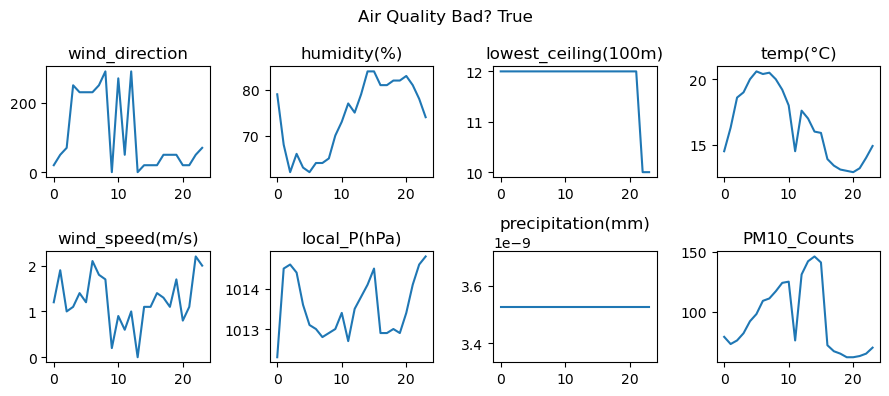

In [7]:
weather, label = next(iter(trainloader))
i = np.random.randint(0, 28)
weather = weather[i]
weather = scaler.inverse_transform(weather.permute(1, 0)).transpose()
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(9, 4))
r = 0
c = 0
for j in range(8):
    axs[r, c].plot(weather[j, :])
    axs[r, c].set_title(f"{feature_names[j+1]}")
    if c < 3:
        c += 1
    else:
        r += 1
        c = 0
fig.suptitle(f"Air Quality Bad? {bool(label[i])}")
plt.tight_layout()
plt.show();

# 2. Model Evaluation

## 2.1. Check on Accuracy on Test Set

In [8]:
test_accuracy = []
test_batch_acc = 0

model.eval()
with torch.no_grad():
    for X, y in testloader:
        y_hat = model(X)  # forward pass to get output
        y_hat_labels = torch.sigmoid(y_hat) > 0.5
        test_batch_acc += (
            (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        )

test_accuracy.append(test_batch_acc / len(testloader))  # accuracy

In [9]:
test_accuracy

[0.8349315017870028]

## 2.2. Prediction

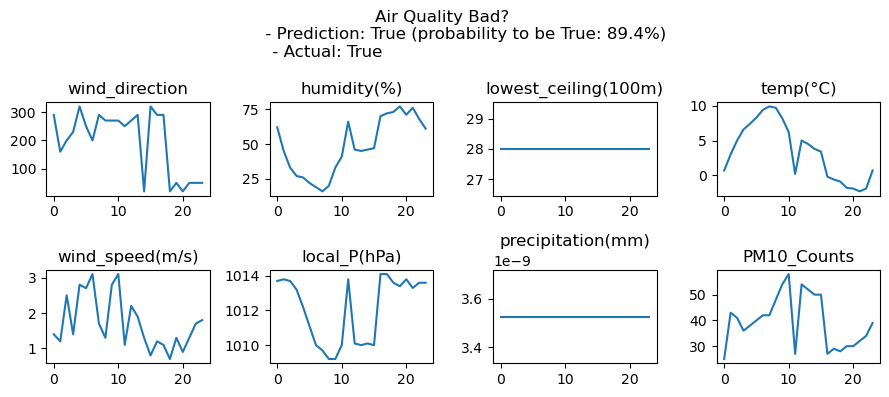

In [10]:
model.eval()
with torch.no_grad():
    wea, lab = next(iter(testloader))
    y_prob = torch.sigmoid(model(wea)[0])
    wea = wea[0]
    wea = scaler.inverse_transform(wea.permute(1, 0)).transpose()
    y_class = int(y_prob > 0.5)
    y_prob_percent = y_prob * 100
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(9, 4))
    r = 0
    c = 0
    for j in range(0, 8):
        axs[r, c].plot(wea[j, :])
        axs[r, c].set_title(f"{feature_names[j+1]}")
        if c < 3:
            c += 1
        else:
            r += 1
            c = 0
    fig.suptitle(
        f"Air Quality Bad? \n \
        - Prediction: {bool(y_class)} (probability to be True: {np.round(y_prob_percent.item(), 1)}%) \n \
        - Actual: {bool(lab[0])}                                                      "
    )
    plt.tight_layout()
    plt.show()
    fig.savefig("../img/prediction_result.png")

## 2.3. AUC/ROC Curve

In [11]:
probabilities = []
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for wea, lab in tqdm(testloader):
        for idx in range(wea.shape[0]):
            y_prob = torch.sigmoid(model(wea)[idx])
            probabilities.append(y_prob.item())
            predictions.append(int(y_prob > 0.5))
            labels.append(lab[idx].item())

100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [00:05<00:00, 27.29it/s]


In [12]:
fpr, tpr, _ = roc_curve(labels, probabilities)

In [13]:
auc_result = auc(fpr, tpr)

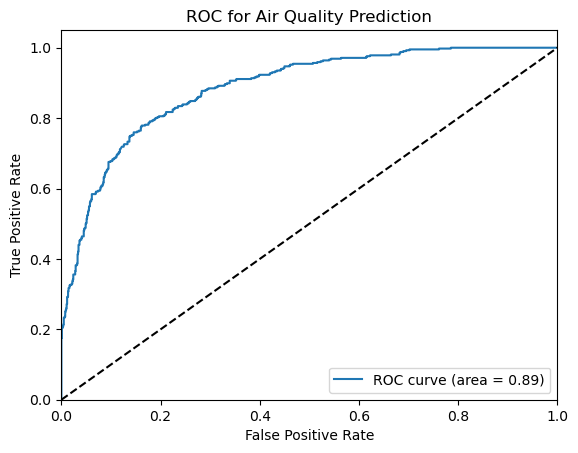

In [14]:
plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc_result)
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Air Quality Prediction")
plt.legend(loc="lower right")
fig = plt.gcf()
fig.savefig("../img/roc_curve.png")
plt.show()

## 2.4. Confusion Matrix / Classification Report

In [15]:
cm = confusion_matrix(labels, predictions)

In [16]:
cm

array([[944,  99],
       [142, 274]], dtype=int64)

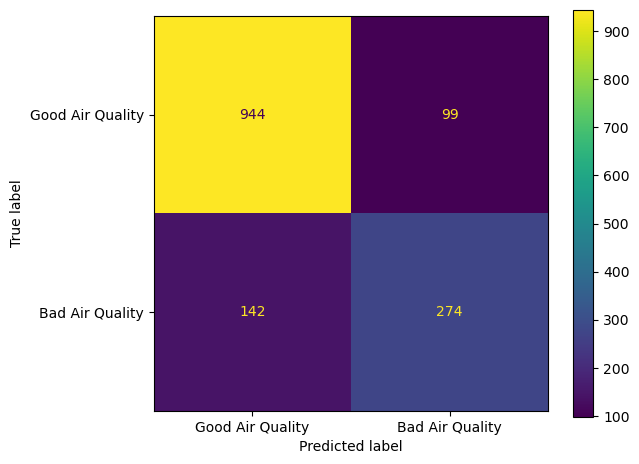

In [17]:
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Good Air Quality", "Bad Air Quality"],
)

cm_display.plot()
plt.tight_layout()
fig = plt.gcf()
fig.savefig("../img/confusion_matrix.png")
plt.show()

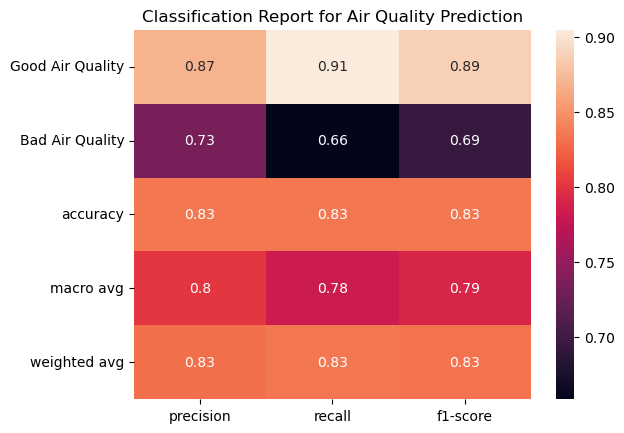

In [18]:
target_names = ["Good Air Quality", "Bad Air Quality"]
clf_report = classification_report(
    labels, predictions, target_names=target_names, output_dict=True
)
clf_plot = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
plt.title("Classification Report for Air Quality Prediction")
clf_plot.figure.savefig("../img/classification.png")
plt.show();